<div style="text-align: center;font-size: 90%;">
<img src="inpe-grande.png" align="center" width=200/>
</div>

<div style="text-align: left;">
    <a href="https://nbviewer.jupyter.org/github/brazil-data-cube/code-gallery/blob/master/jupyter/Python/stac/stac-introduction.ipynb"><img src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg" align="center"/></a>
</div>


<br/>
<div style="text-align: center;font-size: 300%;">
<span style="text-align: center; color:#ff3300">Select FireSpot from BBOX via WFS</span>
</div>
<hr style="border:2px inset #ff9900 ;">

<br/>

<div style="text-align: center;font-size: 90%;color: #cccc00">
    <a href='https://github.com/danielfarkat'>Daniel Farkat<img src='gitnew.png'width=20/></a>
    <br/>
    <a href='mailto:daniel.farkat@inpe.br'>daniel.farkat@inpe.br</a> 
    <br/><br/>
    Applied Computing Division, National Institute for Space Research (INPE)
    <br/>
    Avenida dos Astronautas, 1758, Jardim da Granja, São José dos Campos, SP 12227-010, Brazil
    <br/><br/>
    Last Update: Nov 28, 2024
    
</div>

# Objective

<hr style="border:2px inset #ff9900">

This Notebook is used to select Firespots inside a bbox using the [WebFeatureService](https://www.ogc.org/publications/standard/wfs/) connection from [INPE Programa Queimadas](https://terrabrasilis.dpi.inpe.br/queimadas/portal/) API

## Imports

<hr style="border:2px inset #ff9900">

The first attempet was with the liberys in this table:

| Library       | Version  |
|---------------|----------|
| geopandas     | 1.0.1    |
| requests      | 2.32.3   |
| pandas        | 2.2.3    |
| numpy         | 1.26.4   |
| shapely       | 2.0.6    |
| lxml          | 5.3.0    |
| tqdm          | 4.67.0   |

Try to use the same versions as above so you can beggin by uncomiting the import bellow

In [ ]:
!pip install geopandas==1.0.1 requests==2.32.3 pandas==2.2.3 numpy==1.26.4 shapely==2.0.6 lxml==5.3.0 tqdm==4.67.0


In [1]:
import geopandas as gpd
import requests
import pandas as pd
import numpy as np
import shapely
import lxml
import xml.etree.ElementTree as ET
import tqdm
versions = {
    "geopandas": gpd.__version__,
    "requests": requests.__version__,
    "pandas": pd.__version__,
    "numpy": np.__version__,
    "shapely": shapely.__version__,
    "lxml": lxml.__version__,
    "tqdm": tqdm.__version__
}
from tqdm import tqdm
from shapely import Point
versions



{'geopandas': '1.0.1',
 'requests': '2.32.3',
 'pandas': '2.2.3',
 'numpy': '2.1.3',
 'shapely': '2.0.6',
 'lxml': '5.3.0',
 'tqdm': '4.67.1'}

# Simple Connection

<hr style="border:2px inset #ff9900">

After parsing the full url it is possible to recieve all the firespots in the bbox selected

In [ ]:
new_path= "https://terrabrasilis.dpi.inpe.br/queimadas/geoserver/wfs?SERVICE=WFS&REQUEST=GetFeature&VERSION=2.0.0&TYPENAMES=bdqueimadas3:focos&TYPENAME=bdqueimadas3:focos&SRSNAME=urn:ogc:def:crs:EPSG::4326&BBOX=-18.61361299098762245,-53.45956682213943623,-18.43785514254789248,-53.2000655282666628,urn:ogc:def:crs:EPSG::4326" 

In [ ]:
%time
a = requests.get(new_path)

## Genereta a geodataframe

<hr style="border:2px inset #ff9900">

Run the file and find the variables that we want

In [ ]:
lat = []
lon = []
date = []
xml_data = a.content
root = ET.fromstring(xml_data)
namespaces = {
    'wfs': 'http://www.opengis.net/wfs/2.0',
    'gml': 'http://www.opengis.net/gml/3.2',
    'bdqueimadas3': 'https://www.inpe.br/queimadas/bdqueimadas3'
}
for foco in root.findall('.//wfs:member/bdqueimadas3:focos', namespaces):
    latitude = foco.find('bdqueimadas3:latitude', namespaces).text
    longitude = foco.find('bdqueimadas3:longitude', namespaces).text
    data_hora = foco.find('bdqueimadas3:data_hora_gmt', namespaces).text
    lat.append(latitude)
    lon.append(longitude)
    date.append(data_hora)


Transform in array

In [ ]:
focos_lat = np.array(lat)
focos_lon = np.array(lon)
focos_date = np.array(date)


In [ ]:
result = list(zip(map(lambda x: float(x), focos_lon), map(lambda x: float(x), focos_lat)))

print(result)

create the data frame and print

In [ ]:
d = {'coordinates': result, 'date': focos_date}
df = pd.DataFrame(data=d)

# Criar uma coluna de geometria a partir das coordenadas
df['geometry'] = df['coordinates'].apply(lambda x: Point(x[0], x[1]))

# Converter o DataFrame para um GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Atribuir o CRS diretamente para WGS84 (EPSG:4326)
gdf.crs = {"init": "epsg:4326"}

# Salvar em formato GPKG
gdf.to_file("focos.gpkg", driver="GPKG")



In [ ]:
gdf

<h3 style="text-align: center;font-size: 90%;color: #cccc00"> OPTIONAL STEP</h3>

<hr style="border:2px inset #ff9900">

Above we printed and saved the firespots as geodataframe in the needes areas, so, bellow we will do the second part that is an automatization of the process for an bbox 

In [ ]:
fd = open('focos.xml', 'wb') 
fd.write(a.content)
fd.close()

<h1 style="text-align: center;color:#ff3300""> Create a function </h1>

<hr style="border:2px inset #ff9900">

After successinding in the connection with *[inpe programas queimadas API](https://terrabrasilis.dpi.inpe.br/queimadas/geoserver/ows?SERVICE=WFS&VERSION=1.1.1&REQUEST=Getcapabilities)* it's possible to implement a fuction that automatize the query of firespots in a bbox for a especific range of dates

In [ ]:

caminho_arquivo = "bbox.gpkg"
gdf = gpd.read_file(caminho_arquivo)
lon_min, lat_min, lon_max, lat_max = gdf.total_bounds

# Exibir os valores
print(f"Latitude mínima: {lat_min}")
print(f"Longitude mínima: {lon_min}")
print(f"Latitude máxima: {lat_max}")
print(f"Longitude máxima: {lon_max}")


In [ ]:
year ='2022'
first_month = '09'
first_day = '10'
second_month ='09'
second_day = '15' 
path = f"https://terrabrasilis.dpi.inpe.br/queimadas/geoserver/wfs?SERVICE=WFS&REQUEST=GetFeature&VERSION=2.0.0&TYPENAMES=bdqueimadas3:focos&TYPENAME=bdqueimadas3:focos&SRSNAME=urn:ogc:def:crs:EPSG::4326&CQL_FILTER=data_hora_gmt%20between%20{year}-{first_month}-{first_day}T00%3A00%3A00%20and%20{year}-{second_month}-{second_day}T23%3A59%3A59%20AND%20longitude%20%3E%20{lon_min}%20AND%20longitude%20%3C%20{lon_max}%20AND%20latitude%20%3E%20{lat_min}%20AND%20latitude%20%3C%20{lat_max}"


In [ ]:
a = requests.get(path)

In [ ]:
lat = []
lon = []
date = []
xml_data = a.content
root = ET.fromstring(xml_data)
namespaces = {
    'wfs': 'http://www.opengis.net/wfs/2.0',
    'gml': 'http://www.opengis.net/gml/3.2',
    'bdqueimadas3': 'https://www.inpe.br/queimadas/bdqueimadas3'
}
for foco in root.findall('.//wfs:member/bdqueimadas3:focos', namespaces):
    latitude = foco.find('bdqueimadas3:latitude', namespaces).text
    longitude = foco.find('bdqueimadas3:longitude', namespaces).text
    data_hora = foco.find('bdqueimadas3:data_hora_gmt', namespaces).text
    lat.append(latitude)
    lon.append(longitude)
    date.append(data_hora)

focos_lat = np.array(lat)
focos_lon = np.array(lon)
focos_date = np.array(date)

result = list(zip(map(lambda x: float(x), focos_lon), map(lambda x: float(x), focos_lat)))

print(result)

d = {'coordinates': result, 'date': focos_date}
df = pd.DataFrame(data=d)

# Criar uma coluna de geometria a partir das coordenadas
df['geometry'] = df['coordinates'].apply(lambda x: Point(x[0], x[1]))

# Converter o DataFrame para um GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Atribuir o CRS diretamente para WGS84 (EPSG:4326)
gdf.crs = {"init": "epsg:4326"}

# Salvar em formato GPKG
gdf.to_file("focos.gpkg", driver="GPKG")

<h1 style="text-align: center;color:#ff3300">Representation of firespots</h1>

<hr style="border:2px inset #ff9900">

The representation is shown bellow

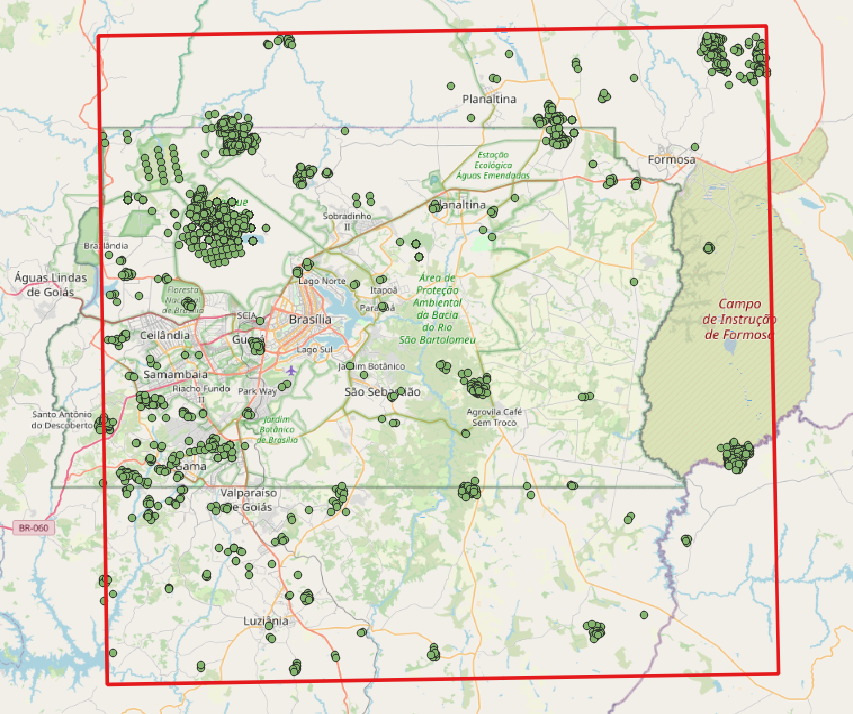

In [ ]:
def cluster_fire_spots(caminho_arquivo="bbox.gpkg", year='2024', first_month='09', first_day='10', second_month='09', second_day='15'):
    """
    # Cluster Fire Spots Function

    This function, `cluster_fire_spots`, allows users to retrieve and analyze fire spot data from the TerraBrasilis database (INPE - Brazilian National Institute for Space Research). 

    ## Overview:
    The function retrieves fire spot data within a specified geographic boundary (using a shapefile or GeoDataFrame) and a specific date range. It queries the TerraBrasilis WFS (Web Feature Service) API for data on fire occurrences (called "focos") based on latitude, longitude, and timestamp.

    ## Parameters:
    - `caminho_arquivo` (str or GeoDataFrame): 
        - The file path to a GeoDataFrame or a shapefile in GPKG format (default: `"bbox.gpkg"`). This file is used to define the geographic boundary for the fire spot search.
        - If a GeoDataFrame is provided, it will automatically extract the boundary limits from it.
    - `year` (str): The year to filter the fire spots (default: `'2022'`).
    - `first_month` (str): The first month of the date range to filter fire spots (default: `'09'`).
    - `first_day` (str): The first day of the date range to filter fire spots (default: `'10'`).
    - `second_month` (str): The second month of the date range to filter fire spots (default: `'09'`).
    - `second_day` (str): The second day of the date range to filter fire spots (default: `'15'`).

    ## Returns:
    - A GeoDataFrame containing the fire spot data, including coordinates (latitude and longitude) and the corresponding timestamp of each fire occurrence.
    - The function also saves the resulting data as a GeoPackage file (`focosat_bbox.gpkg`).

    ## Usage Example:
    ```python
    gdf = cluster_fire_spots(caminho_arquivo="my_shapefile.gpkg", year='2023', first_month='01', first_day='01', second_month='01', second_day='15')
    print(gdf.head())
    """
    # Progress bar for GeoDataFrame or shapefile handling
    if isinstance(caminho_arquivo, gpd.GeoDataFrame):
        print("Processing GeoDataFrame for boundaries...")
        lon_min, lat_min, lon_max, lat_max = caminho_arquivo.total_bounds
        gdf = print_points(lat_min, lon_min, lat_max, lon_max, year, first_month, first_day, second_month, second_day)
    else:
        try:
            print("Reading file and extracting boundaries...")
            with tqdm(total=100, desc="Reading File") as pbar:
                gdf = gpd.read_file(caminho_arquivo)
                lon_min, lat_min, lon_max, lat_max = gdf.total_bounds
                pbar.update(100)
            
            print("Processing points from file boundaries...")
            gdf = print_points(lat_min, lon_min, lat_max, lon_max, year, first_month, first_day, second_month, second_day)
            return gdf
        except Exception as e:
            print(f"Error: {e}")
            return False
    return gdf


def print_points(lat_min, lon_min, lat_max, lon_max, year, first_month, first_day, second_month, second_day):
    # Displaying boundaries
    print(f"Latitude mínima: {lat_min}")
    print(f"Longitude mínima: {lon_min}")
    print(f"Latitude máxima: {lat_max}")
    print(f"Longitude máxima: {lon_max}")

    # Generating request URL
    path = f"https://terrabrasilis.dpi.inpe.br/queimadas/geoserver/wfs?SERVICE=WFS&REQUEST=GetFeature&VERSION=2.0.0&TYPENAMES=bdqueimadas3:focos&TYPENAME=bdqueimadas3:focos&SRSNAME=urn:ogc:def:crs:EPSG::4326&CQL_FILTER=data_hora_gmt%20between%20{year}-{first_month}-{first_day}T00%3A00%3A00%20and%20{year}-{second_month}-{second_day}T23%3A59%3A59%20AND%20longitude%20%3E%20{lon_min}%20AND%20longitude%20%3C%20{lon_max}%20AND%20latitude%20%3E%20{lat_min}%20AND%20latitude%20%3C%20{lat_max}"
    print("Fetching data from TerraBrasilis...")
    
    with tqdm(total=100, desc="Downloading Data") as pbar:
        response = requests.get(path)
        pbar.update(100)
    
    lat, lon, date = [], [], []
    xml_data = response.content
    root = ET.fromstring(xml_data)
    namespaces = {
        'wfs': 'http://www.opengis.net/wfs/2.0',
        'gml': 'http://www.opengis.net/gml/3.2',
        'bdqueimadas3': 'https://www.inpe.br/queimadas/bdqueimadas3'
    }

    print("Processing fire spot data...")
    for foco in tqdm(root.findall('.//wfs:member/bdqueimadas3:focos', namespaces), desc="Processing Fire Spots"):
        latitude = foco.find('bdqueimadas3:latitude', namespaces).text
        longitude = foco.find('bdqueimadas3:longitude', namespaces).text
        data_hora = foco.find('bdqueimadas3:data_hora_gmt', namespaces).text
        lat.append(latitude)
        lon.append(longitude)
        date.append(data_hora)

    focos_lat = np.array(lat)
    focos_lon = np.array(lon)
    focos_date = np.array(date)

    print("Creating GeoDataFrame...")
    
    result = list(zip(map(lambda x: float(x), focos_lon), map(lambda x: float(x), focos_lat)))
    d = {'coordinates': result, 'date': focos_date}
    df = pd.DataFrame(data=d)
    df['geometry'] = df['coordinates'].apply(lambda x: Point(x[0], x[1]))
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    gdf.crs = {"init": "epsg:4326"}
    gdf.to_file("new_2024_focosaalto_bbox.gpkg", driver="GPKG")
    print("GeoDataFrame saved successfully as 'focosaalto_bbox.gpkg'")
    return gdf 


In [ ]:
gdf = cluster_fire_spots(caminho_arquivo="bbox.gpkg", year='2024', first_month='01', first_day='01', second_month='11', second_day='30')

Reading file and extracting boundaries...


Reading File: 100%|██████████| 100/100 [00:00<00:00, 12702.31it/s]


Processing points from file boundaries...
Latitude mínima: -16.334349804944434
Longitude mínima: -48.205922378629374
Latitude máxima: -15.359071662752235
Longitude máxima: -47.165960838884224
Fetching data from TerraBrasilis...


Processing fire spot data...


Processing Fire Spots: 100%|██████████| 11760/11760 [00:00<00:00, 147910.85it/s]

Creating GeoDataFrame...



/home/queimadas/miniconda3/envs/bdclab/lib/python3.10/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


GeoDataFrame saved successfully as 'focosaalto_bbox.gpkg'


In [27]:
gdf

,coordinates,date,geometry
0,"(-47.86825, -16.20475)",2024-06-30T17:32:00-03:00,POINT (-47.86825 -16.20475)
1,"(-47.86354, -16.20375)",2024-06-30T17:32:00-03:00,POINT (-47.86354 -16.20375)
2,"(-47.73696, -15.99924)",2024-06-30T17:32:00-03:00,POINT (-47.73696 -15.99924)
3,"(-47.73662, -15.9982)",2024-06-30T17:32:00-03:00,POINT (-47.73662 -15.9982)
4,"(-47.99172, -15.93697)",2024-06-30T17:32:00-03:00,POINT (-47.99172 -15.93697)
...,...,...,...
11755,"(-48.03136, -15.57028)",2024-06-30T16:41:00-03:00,POINT (-48.03136 -15.57028)
11756,"(-48.0319, -15.56694)",2024-06-30T16:41:00-03:00,POINT (-48.0319 -15.56694)
11757,"(-47.61009, -15.42268)",2024-06-30T16:41:00-03:00,POINT (-47.61009 -15.42268)
11758,"(-47.57429, -15.3935)",2024-06-30T16:41:00-03:00,POINT (-47.57429 -15.3935)


# Dates and locations 


search for fire burnspots in the interval between the day before and the day after of the i location 76 in the image processing file

2022-09-11
2022-09-14

In [28]:
gdf = cluster_fire_spots(caminho_arquivo="bbox.gpkg", year='2024', first_month='09', first_day='11', second_month='09', second_day='14')

Reading file and extracting boundaries...


Reading File: 100%|██████████| 100/100 [00:00<00:00, 1606.89it/s]


Processing points from file boundaries...
Latitude mínima: -16.334349804944434
Longitude mínima: -48.205922378629374
Latitude máxima: -15.359071662752235
Longitude máxima: -47.165960838884224
Fetching data from TerraBrasilis...


Processing fire spot data...


Processing Fire Spots: 100%|██████████| 957/957 [00:00<00:00, 149389.59it/s]
/home/queimadas/miniconda3/envs/bdclab/lib/python3.10/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Creating GeoDataFrame...
GeoDataFrame saved successfully as 'focosaalto_bbox.gpkg'


In [31]:
gdf.to_file("focos_2022.gpkg", driver="GPKG")

In [35]:
gdf = gdf.to_crs(epsg=32733)
novo_buffer = gdf.buffer(1000)

gdf_novo_buffer = gpd.GeoDataFrame(geometry=novo_buffer, crs=gdf.crs)

gdf_dissolvido = gdf_novo_buffer.dissolve()

gdf_dissolvido.to_file("buffer.gpkg", driver="GPKG")


# Thats all 

<hr style="border:2px inset #ff9900">

By the end, the identification of fire spots in the bbox it's done 

## Important information 

<hr style="border:2px inset #ff9900">

All the project was done considering the intrance bbox in EPSG 4236.


